In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, HdpModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
from gensim.parsing.preprocessing import strip_tags, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, preprocess_string

from tqdm import tqdm_notebook as tqdm


# Cleaning

In [2]:
df = pd.read_csv('NLT_data/merged_data.csv')

In [4]:
# filling some missing abstract values with the discussion section
df['abstract'] = df['abstract'].fillna(value = df['discussion'])
# Filling the rest with the title value
df['abstract'] = df['abstract'].fillna(value = df['title'])

In [5]:
# funtion for cleaning text
def preprocess(text):
    ls = []
    for i in tqdm(text):
        custom_filters = [strip_tags, strip_punctuation, strip_multiple_whitespaces, 
                          remove_stopwords]
        ls.append(preprocess_string(i.lower(), custom_filters))
    return ls

In [6]:
raw_data = df['abstract']

In [7]:
data = preprocess(raw_data)

/Users/cynthia/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


# Doc2vec Model Training

In [8]:
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield TaggedDocument(list_of_words, [i])

In [9]:
data_tagged = list(create_tagged_document(data))

In [10]:
model = Doc2Vec(vector_size = 200, min_count = 3, epochs = 20)

In [11]:
model.build_vocab(data_tagged)

In [14]:
%%time # trained on data_tagged instead of train_tagged (??)
model.train(data_tagged, total_examples = model.corpus_count, epochs = model.epochs)

CPU times: user 4min 21s, sys: 7.22 s, total: 4min 28s
Wall time: 1min 51s


In [15]:
model.save('doc2vec.model')

In [ ]:
# How to load in save model
# model = Doc2Vec.load('doc2vec.model')

# Get Similar Docs

In [16]:
model.docvecs.most_similar(1)

[(18789, 0.6808946132659912),
 (12634, 0.6662856936454773),
 (21785, 0.6614649295806885),
 (1730, 0.6590951681137085),
 (20977, 0.6584314703941345),
 (14977, 0.6571099162101746),
 (36091, 0.6566710472106934),
 (18031, 0.6557404398918152),
 (18929, 0.6535806655883789),
 (31824, 0.6525307297706604)]

In [17]:
model.wv.most_similar_cosmul('virus')

[('viruses', 0.8659990429878235),
 ('viral', 0.8270898461341858),
 ('pathogen', 0.774575412273407),
 ('coronaviruses', 0.7464132308959961),
 ('pathogens', 0.7445506453514099),
 ('coronavirus', 0.7295480966567993),
 ('virion', 0.7247394323348999),
 ('cov', 0.7110444903373718),
 ('virions', 0.7086395025253296),
 ('rna', 0.7073073983192444)]

In [164]:
# Previous output (didn't rerun)
model.docvecs.most_similar(1)

[(1731, 0.5637912750244141),
 (12634, 0.5543673038482666),
 (19038, 0.5514589548110962),
 (18009, 0.5503606796264648),
 (18789, 0.5487930178642273),
 (34402, 0.5486491918563843),
 (20667, 0.5466043949127197),
 (772, 0.5355071425437927),
 (21257, 0.5311373472213745),
 (20033, 0.5282373428344727)]

In [172]:
# Previous output (didn't rerun)
model.wv.most_similar_cosmul('virus')

[('viruses', 0.8687520623207092),
 ('viral', 0.8277767300605774),
 ('pathogen', 0.7806078791618347),
 ('coronaviruses', 0.7566280364990234),
 ('pathogens', 0.7309069633483887),
 ('coronavirus', 0.7308399081230164),
 ('virion', 0.7137243747711182),
 ('antibody', 0.7089149951934814),
 ('adenovirus', 0.7068344950675964),
 ('prv', 0.7008906602859497)]

In [18]:
# Original function
def search_docs(word, number_of_articles):
    new_vec = model.infer_vector([word])
    tag_list = model.docvecs.most_similar([new_vec])[0:number_of_articles]
    sims = []
    tags = []
    for num in tag_list:
        tags.append(num[0])
        sims.append(num[1])
    dfs = []
    for t in tags:
        dfs.append(df.iloc[t, :])
    new_df = pd.DataFrame(dfs)
    new_df['similarity_percentage'] = sims
    return new_df

In [19]:
search_docs('virus', 4)

,paper_id,source,title,abstract,publish_time,authors,journal,url,discussion,text_body,similarity_percentage
17193,bd00819b4de2a4763e39eb6f5d64ada0ec42e1ec,PMC,Human Metapneumovirus,Name of Virus: Human metapneumovirus,2013-08-26,"Garcia–Moliner, Maria L.",Viruses and the Lung,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,"Human metapneumovirus (hMPV), a frequent cause...",0.889753
2457,7a31ec5e53aa0adf7ae3f8caa2b02b72d2123f37,PMC,Genomics and computational science for virus r...,Genomics and computational science for virus r...,2013-03-07,"Sato, Hironori; Yokoyama, Masaru; Toh, Hiroyuki",Front Microbiol,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN,"RNA viruses are highly mutable, yet changes in...",0.853033
26158,40bff06a9348c4f493fe2ab947182e49876a5e59,Elsevier,Enfermedad por virus Ébola y seguridad de las/...,Enfermedad por virus Ébola y seguridad de las/...,2015-08-31,"Vizcaya-Moreno, M. Flores; Mercedes Núñez del ...",Gaceta Sanitaria,https://doi.org/10.1016/j.gaceta.2015.02.011,NaN,None declared.Conceived the idea of the report...,0.850008
20977,dfe5e0999792db3c59734c164e1dd19830e8e4a9,Elsevier,Lessons Learned During the COVID-19 Virus Pand...,Lessons Learned During the COVID-19 Virus Pand...,2020-03-27,"Sterpetti, Antonio V.",Journal of the American College of Surgeons,https://doi.org/10.1016/j.jamcollsurg.2020.03.018,NaN,"Antonio V Sterpetti, MD Covid-19 is a new stra...",0.849465


In [29]:
# Grab most similar articles of the input word and its most similar words 
def most_sim_docs(word, n_articles, topn=3):
    dfs = []
    sims = []
    
    # Input word with topn of its most similar keywords
    keywords = [word] + [w[0] for w in model.wv.most_similar_cosmul(word, topn=topn)]
    
    # Loop through each keyword
    for term in keywords:
        new_vec = model.infer_vector([term]) # random, different everytime 
        tag_list = model.docvecs.most_similar([new_vec])[0:n_articles]
        
        
        tags = [] 
        for num in tag_list:
            tags.append(num[0])
            sims.append(num[1])
        
        for t in tags:
            dfs.append(df.iloc[t, :])
        
    new_df = pd.DataFrame(dfs)
    new_df['similarity_percentage'] = sims
    
    return new_df

In [39]:
articles = most_sim_docs('virus', 2)

In [54]:
articles

,paper_id,source,title,abstract,publish_time,authors,journal,url,discussion,text_body,similarity_percentage
17193,bd00819b4de2a4763e39eb6f5d64ada0ec42e1ec,PMC,Human Metapneumovirus,Name of Virus: Human metapneumovirus,2013-08-26,"Garcia–Moliner, Maria L.",Viruses and the Lung,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,"Human metapneumovirus (hMPV), a frequent cause...",0.854331
26158,40bff06a9348c4f493fe2ab947182e49876a5e59,Elsevier,Enfermedad por virus Ébola y seguridad de las/...,Enfermedad por virus Ébola y seguridad de las/...,2015-08-31,"Vizcaya-Moreno, M. Flores; Mercedes Núñez del ...",Gaceta Sanitaria,https://doi.org/10.1016/j.gaceta.2015.02.011,NaN,None declared.Conceived the idea of the report...,0.846515
20099,8262ee018c3a68115e490eabef19cacb5442647e,Elsevier,Viruses and the pathogenesis of multiple scler...,Viruses and the pathogenesis of multiple scler...,1984-03-31,"Whitaker, John N.; Kingsbury, David W.",Trends in Neurosciences,https://doi.org/10.1016/s0166-2236(84)80155-1,NaN,The tachykinin family of peptides ( Fig. 1) i...,0.878737
10734,c51c4f6146d0c636bc4dc3839c16b9e3ef52849a,PMC,Haunted with and hunting for viruses,Haunted with and hunting for viruses,2013-08-07,"Gao, George Fu; Wu, Ying",Sci China Life Sci,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,pecially with next-generation sequencing (NGS)...,0.876750
33324,68a0767d279c9c1d3d7c83a5796128d370f917b4,Elsevier,Multiple sclerosis as a viral disease,Multiple sclerosis as a viral disease,1989-12-31,"Brahic, M.; Jewell, J.",Research in Immunology,https://doi.org/10.1016/0923-2494(89)90082-5,NaN,the MHC and T-cell-receptor peptides involved ...,0.859991
33801,251bc368c4c2d41d0a3e44ebb499c12b4a923b92,Elsevier,Viral diseases of companion birds,Viral diseases of companion birds,2005-01-31,"Greenacre, Cheryl B.",Veterinary Clinics of North America: Exotic An...,https://doi.org/10.1016/j.cvex.2004.09.005,NaN,"Because adenoviruses are nonenveloped viruses,...",0.826255
34784,9f8f05f2fa2a9f116b4a9a6449e3bca83f2ee552,Elsevier,Canine Coronavirus: Not Only an Enteric Pathogen,Canine Coronavirus: Not Only an Enteric Pathogen,2011-11-30,"Decaro, Nicola; Buonavoglia, Canio",Veterinary Clinics of North America: Small Ani...,https://doi.org/10.1016/j.cvsm.2011.07.005,NaN,"of a short amino-terminal ectodomain, a triple...",0.770511
30297,1be620d0f0c65a6df3caa6d57c1dfeee0f9945f3,Elsevier,The pathogens,The pathogens,2007-10-31,"Carman, William F.; Mahony, James B.",Journal of Clinical Virology,https://doi.org/10.1016/s1386-6532(07)70003-3,NaN,Respiratory viruses are important to human hea...,0.762521


In [49]:
title = articles.iloc[0]['title']

In [50]:
title

'Human Metapneumovirus'

In [52]:
articles.iloc[0]['text_body'][:100]

'Human metapneumovirus (hMPV), a frequent cause of acute respiratory illness in young children, was f'

# KMeans

In [65]:
X = model.docvecs.vectors_docs

In [69]:
ss = StandardScaler()

Xs = ss.fit_transform(X)

In [71]:
pca = PCA(random_state = 666)

In [72]:
Z = pca.fit_transform(Xs)

In [145]:
km = KMeans(n_clusters = 5, random_state = 666)

In [146]:
km.fit(Z)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=666, tol=0.0001, verbose=0)

In [147]:
y_means = km.predict(Z)

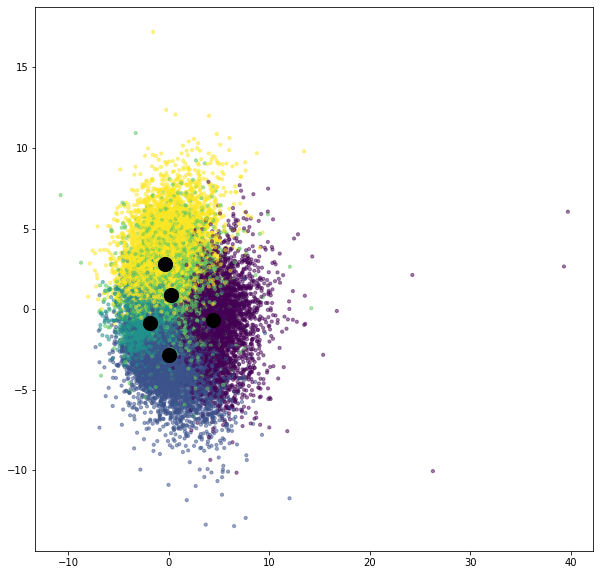

In [213]:
plt.figure(figsize=(10,10))
plt.scatter(Z[:, 0], Z[:, 1], c = y_means, s = 10, alpha = .5)
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c= 'black', s = 200)
plt.xlim()